In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [187]:
def create_year_dataframe(year):
    df = pd.read_csv("survey_results_public_" + str(year) + ".csv", low_memory=False)
    return df

In [188]:
years_data = [2015, 2016, 2017, 2018, 2019]

In [189]:
def create_all_dataframes(all_years):
    dict_df = {}
    for year in years_data:
        dict_df[year] = create_year_dataframe(year)
    return dict_df

In [190]:
all_years = create_all_dataframes(years_data)

In [191]:
#cleaning 2015 headers
columns_2015 = all_years[2015].iloc[0]
all_years[2015] = all_years[2015][1:]
all_years[2015].columns = columns_2015

In [192]:
def segment_by_column_and_value(df, column, value):
    return df[df[column]==value]

In [193]:
all_years[2016].rename(columns={"country":"Country"}, inplace=True)

In [194]:
def create_column_df(df_dict, column, value):
    dictionary = {}
    for key in df_dict:
        dictionary[key] = segment_by_column_and_value(df_dict[key], column, value)
    return dictionary

In [195]:
united_states = create_column_df(all_years, "Country", "United States")

<H2> Question 1: How has the survey changed over the years? </h2>

In [196]:
def get_yearly_shape(dictionary, year):
    return dictionary[year].shape[0], dictionary[year].shape[1]

In [197]:
def get_all_shapes(dictionary, years):
    rows = []
    columns = []
    for year in years:
        rows.append(get_yearly_shape(dictionary, year)[0])
        columns.append(get_yearly_shape(dictionary, year)[1])
    df = pd.DataFrame(list(zip(rows, columns, years)), columns=["NumberOfRespondents", "NumberOfQuestions", "Year"])
    return df
        

In [198]:
yearly_shapes = get_all_shapes(united_states, [2015, 2016, 2017, 2018, 2019])

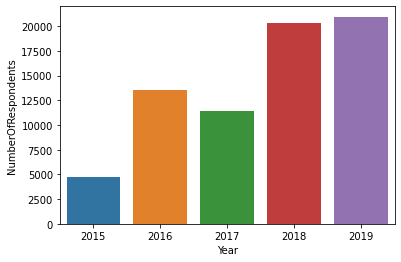

In [199]:
sns.barplot(x="Year", y="NumberOfRespondents", data=yearly_shapes)

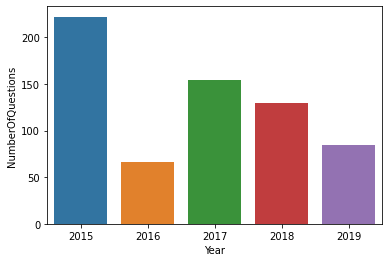

In [200]:
sns.barplot(x="Year", y="NumberOfQuestions", data=yearly_shapes)

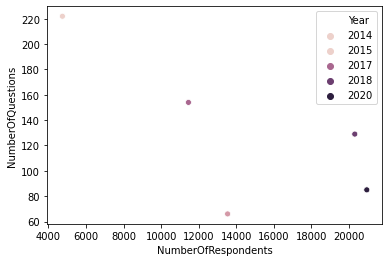

In [201]:
sns.scatterplot(x="NumberOfRespondents", y="NumberOfQuestions", hue="Year", data=yearly_shapes)

<H2> Question 2: How have the most common occupations changed in the United States over the last 3 years </h2>

In [202]:
def segment_by_column_and_value(df, column, value):
    return df[df[column]==value]

In [203]:
def create_value_df(df, year, column, column_name):
    new_df = pd.DataFrame(df[year][column].value_counts()).reset_index()
    new_df.columns=[column_name, "Count"]
    new_df["Percentage"] = new_df["Count"]/sum(new_df["Count"])
    new_df = new_df.replace("(?i).*mobile.*", "Mobile", regex=True)
    new_df = new_df.groupby("DeveloperType", as_index=False).sum()
    new_df["Year"] = year
    new_df.sort_values("Percentage", ascending=False, inplace=True)
    return new_df

In [204]:
def split_words(df, year, column, column_name):
    all_the_words = defaultdict(int) 
    for row in df[year][column]:
        if isinstance(row, float):
            all_the_words[row] += 1
        else:
            for word in row.split(";"):
                all_the_words[word.strip()] += 1
    new_df = pd.DataFrame(pd.Series(all_the_words)).reset_index()
    new_df.columns = [column_name, "Count"]
    new_df["Percentage"] = new_df["Count"] / sum(new_df["Count"])
    new_df["Year"] = year
    new_df.sort_values('Percentage', ascending=False, inplace=True)
    return new_df

In [205]:
occupation_2015 = create_value_df(united_states, 2015, "Occupation", "DeveloperType")
occupation_2016 = create_value_df(united_states, 2016, "occupation", "DeveloperType")
#occupation_2017 = split_words(all_years, 2017, "DeveloperType", "DeveloperType")
occupation_2018 = split_words(united_states, 2018, "DevType", "DeveloperType")
occupation_2019 = split_words(united_states, 2019, "DevType", "DeveloperType")

In [206]:
occupation_df = occupation_2015.append(occupation_2016).append(occupation_2018).append(occupation_2019)

In [207]:
def standardize_developer_types(df, regexes, words):
    new_df = df.replace(regexes, words, regex=True)
    return new_df

In [208]:
regexes = ["(?i).*full-stack.*", "(?i).*back-end.*", "(?i).*front-end.*", "(?i).*embedded.*", "(?i).*desktop.*", "(?i).*executive.*", "(?i).*devops.*", "(?i).*mobile.*" ] 
words = ["Full-stack", "Back-end", "Front-end", "Embedded", "Desktop", "Executive", "DevOps", "Mobile"]
developer_types = ["Full-stack", "Front-end", "Back-end", "Mobile", "Student", "Desktop"]

In [209]:
standardized_data_df = standardize_developer_types(occupation_df, regexes, words)

In [210]:
graph_data = standardized_data_df[standardized_data_df["DeveloperType"].isin(developer_types)]

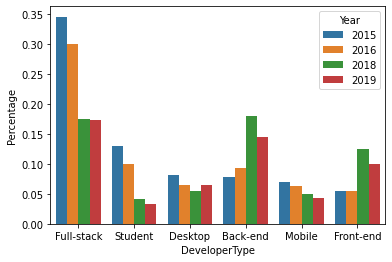

In [211]:
sns.barplot(x="DeveloperType", y="Percentage", hue="Year", data=graph_data)

<h2> Question 3: What attributes affected American salaries most in 2019? </h2>

In [212]:
united_states[2019].shape[0], united_states[2019].shape[1]

(20949, 85)

In [213]:
# There are 20,000 rows and 85 columns in 2019. Let's see what columns have missing data

<h3> Data Understanding </h3>

In [214]:
united_states[2019]["CompTotal"].isna().mean()

0.28340254904768725

In [215]:
#28 percent of the data is empty. Since CompTotal is our dependent variable, I'm going to drop all rows
# without CompTotal from our analysis

In [216]:
test_data = united_states[2019].dropna(subset=["CompTotal"])

In [217]:
missing_cols = set(test_data.columns[test_data.isna().mean()>.2])

In [218]:
missing_cols

{'BlockchainIs',
 'BlockchainOrg',
 'CodeRevHrs',
 'DatabaseDesireNextYear',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'SOHowMuchTime',
 'SONewContent',
 'WebFrameDesireNextYear',
 'WebFrameWorkedWith'}

In [219]:
#10 features are missing more than 20 percent of the data. Let's review them

In [220]:
test_data["BlockchainOrg"]

3                                        Not at all
12                                       Not at all
21                                       Not at all
22                                              NaN
25                                       Not at all
                            ...                    
88312                                    Not at all
88321                                           NaN
88323                                           NaN
88324    Implementing cryptocurrency-based products
88325                                    Not at all
Name: BlockchainOrg, Length: 15012, dtype: object

In [221]:
#I'm going to convert this column to a categorical variable with NaNs as their own column

In [222]:
#Let's checkout BlockchainIs next

In [223]:
test_data["BlockchainIs"]

3        Useful for decentralized currency (i.e., Bitcoin)
12       Useful for decentralized currency (i.e., Bitcoin)
21                                                     NaN
22       Useful for immutable record keeping outside of...
25                                           A passing fad
                               ...                        
88312                    An irresponsible use of resources
88321                                                  NaN
88323                                        A passing fad
88324                    An irresponsible use of resources
88325    Useful for decentralized currency (i.e., Bitcoin)
Name: BlockchainIs, Length: 15012, dtype: object

In [224]:
# Will handles the same as BlockChainOrg

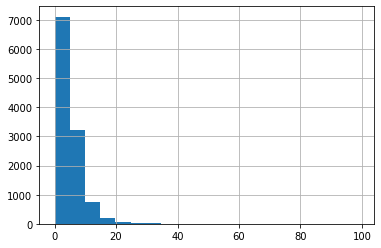

In [225]:
test_data["CodeRevHrs"].hist(bins=20)

In [226]:
# The graph is right skewed, so I will fill NaNs with the median value

In [227]:
test_data['DatabaseDesireNextYear']

3                                            MySQL;SQLite
12                                   Firebase;MySQL;Redis
21                       Elasticsearch;MySQL;Oracle;Redis
22       Couchbase;DynamoDB;Elasticsearch;Firebase;Oracle
25                Microsoft SQL Server;MySQL;Redis;SQLite
                               ...                       
88312                         Firebase;MongoDB;PostgreSQL
88321                                                 NaN
88323                                            DynamoDB
88324                                              Oracle
88325                                          PostgreSQL
Name: DatabaseDesireNextYear, Length: 15012, dtype: object

In [228]:
# I'm going to convert this to a number of desired database to learn and dummy columns. 
# We will do the same with DevType
# Nan will be a dummy variable and 0 

In [229]:
test_data["MiscTechDesireNextYear"]

3                                                     .NET
12                                      Node.js;TensorFlow
21                                                 Node.js
22                                 React Native;TensorFlow
25                                  .NET;.NET Core;Node.js
                               ...                        
88312                                              Node.js
88321                                                  NaN
88323    Apache Spark;CryEngine;Hadoop;.NET;.NET Core;T...
88324                                         Apache Spark
88325                                              Node.js
Name: MiscTechDesireNextYear, Length: 15012, dtype: object

In [230]:
# Same as before

In [231]:
test_data['MiscTechWorkedWith']

3                                          .NET
12                              Node.js;Xamarin
21                                      Node.js
22                                          NaN
25               .NET;.NET Core;Node.js;Xamarin
                          ...                  
88312                                   Node.js
88321            Apache Spark;Pandas;TensorFlow
88323    Apache Spark;Hadoop;.NET Core;Unity 3D
88324                              Apache Spark
88325                                   Node.js
Name: MiscTechWorkedWith, Length: 15012, dtype: object

In [232]:
# Same as before

In [233]:
test_data["SOHowMuchTime"]

3        31-60 minutes
12       11-30 minutes
21        0-10 minutes
22                 NaN
25       11-30 minutes
             ...      
88312    11-30 minutes
88321      60+ minutes
88323      60+ minutes
88324    11-30 minutes
88325     0-10 minutes
Name: SOHowMuchTime, Length: 15012, dtype: object

In [234]:
# will try categorical dummy variables

In [235]:
test_data["SONewContent"].value_counts()

Tech articles written by other developers;Industry news about technologies you're interested in;Tech meetups or events in your area;Courses on technologies you're interested in    2077
Tech articles written by other developers                                                                                                                                           1054
Tech meetups or events in your area                                                                                                                                                  902
Tech articles written by other developers;Industry news about technologies you're interested in                                                                                      814
Tech articles written by other developers;Courses on technologies you're interested in                                                                                               802
Courses on technologies you're interested in                               

In [236]:
# same as databases

In [237]:
test_data["WebFrameDesireNextYear"]

3                                               NaN
12                                   Express;Vue.js
21                 Angular/Angular.js;Ruby on Rails
22            Express;React.js;Ruby on Rails;Vue.js
25                       Angular/Angular.js;ASP.NET
                            ...                    
88312    Angular/Angular.js;Express;React.js;Vue.js
88321                                           NaN
88323                                           NaN
88324                                     Other(s):
88325                            React.js;Other(s):
Name: WebFrameDesireNextYear, Length: 15012, dtype: object

In [238]:
# same as databases

In [239]:
test_data["WebFrameWorkedWith"]

3                                                      NaN
12        Angular/Angular.js;ASP.NET;Express;jQuery;Vue.js
21                        Angular/Angular.js;Ruby on Rails
22                                  React.js;Ruby on Rails
25       Angular/Angular.js;ASP.NET;Drupal;Express;jQue...
                               ...                        
88312                           Angular/Angular.js;Express
88321                                                  NaN
88323                                                  NaN
88324                                            Other(s):
88325                                   React.js;Other(s):
Name: WebFrameWorkedWith, Length: 15012, dtype: object

In [240]:
# same as database

<h3> Preparing Data </h3>
    
   We need to convert the following to dummy columns
    
   <ul> 
   <li> WebFrameWorkedWith</li>
   <li> DevType </li>
   <li> WebFrameDesireNextYear </li>
   <li> SONewContent </li>
   <li> MiscTechWorkedWith </li>
   <li> MiscTechDesireNextYear </li>
   <li> DatabaseDesireNextYear</li>
   </ul>  
   
   We need to fill empty values for the following
   
   <ul> 
    <li> BlockchainIs </li>
    <li> BlockchainOrg </li>
    <li> CodeRevHrs </li>
    <li> SOHowMuchTime </li>
   </ul>

In [241]:
#First let's create number of skills columns for all the columns in the first group

In [242]:
def create_number_of_skills(x):
    if isinstance(x, str):
        return len(x.split(';'))
    return 0

In [243]:
test_data["NumberOfWebFramesWorkedWith"] = test_data["WebFrameWorkedWith"].apply(create_number_of_skills)
test_data["NumberOfDevType"] = test_data["DevType"].apply(create_number_of_skills)
test_data["NumberOfWebFrameDesireNextYear"] = test_data["WebFrameDesireNextYear"].apply(create_number_of_skills)
test_data["NumberOfSONewContent"] = test_data["SONewContent"].apply(create_number_of_skills)
test_data["NumberOfMiscTechWorkedWith"] = test_data["MiscTechWorkedWith"].apply(create_number_of_skills)
test_data["NumberOfMiscTechDesireNextYear"] = test_data["MiscTechDesireNextYear"].apply(create_number_of_skills)
test_data["NumberOfDatabaseDesireNextYear"] = test_data["DatabaseDesireNextYear"].apply(create_number_of_skills)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [278]:
def create_dummies(df, lst):
    for item in lst:
        print(item)
        new_df = df[item].str.get_dummies(sep=";").add_prefix(item + "_")
        df = df.join(new_df)
    return df

In [245]:
def get_possible_options(df, column):
    lst = []
    for row in df[column]:
        if isinstance(row, str):
            for item in row.split(';'):
                if item not in lst:
                    lst.append(item)
    return lst

In [285]:
needs_dummies = ["WebFrameWorkedWith", "WebFrameDesireNextYear", "DevType", "SONewContent", "MiscTechWorkedWith", 
                 "MiscTechDesireNextYear","DatabaseDesireNextYear"]

In [286]:
tst = create_dummies(test_data, needs_dummies)

WebFrameWorkedWith
WebFrameDesireNextYear
DevType
SONewContent
MiscTechWorkedWith
MiscTechDesireNextYear
DatabaseDesireNextYear


In [288]:
# Part 1 is done